# Advanced Lane Finding

## Importing Packages

In [3]:
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np

from moviepy.editor import VideoFileClip
from IPython.display import HTML

# My humble tribute to Michael Jordan, 
# the best basketball player ever.
np.random.seed(23)

%matplotlib inline

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.0122880/28549024 bytes (0.4409600/28549024 bytes (1.4417792/28549024 bytes (1.5761856/28549024 bytes (2.7909312/28549024 bytes (3.21040384/28549024 bytes (3.6%1187840/28549024 bytes (4.2%1204224/28549024 bytes (4.2%1335296/28549024 bytes (4.7%1449984/28549024 bytes (5.1%1548288/28549024 bytes (5.4%1662976/28549024 bytes (5.8%1777664/28549024 bytes (6.2%1859584/28549024 bytes (6.5%1974272/28549024 bytes (6.9%2088960/28549024 bytes (7.3%2170880/28549024 bytes (7.6%2252800/28549024 bytes (7.9%2351104/28549024 bytes (8.2%2531328/28549024 bytes (8.9%2744320/28549024 bytes (9.6%2940928/28549024 bytes (10.33153920/28549024 bytes (11.03383296/28549024 bytes (11.93612672/28549024 bytes (12.73842048/28549024 bytes (13.54055040/28549024 bytes (14.24268032/28549024 bytes (14.9448

## Step by step plan

In this notebook we will aim to clearly isolate the portion of the road between two lane lines, on a road. This is how we will proceed:

- Camera calibration: our camera lenses distort the way the geometry appears in reality. We must recalibrate it using a chessboard in order to transform the feed into images fathfull to ground truth.

- Finding lanes using Color and Gradient. A mix of the Sobel filter and S gradient will do. 
- Process each image and apply a perspective transform.
- Were the previous lines determined with enough confidence?
    - If not, determine where the lines are with a histogram.
    - Keep all candidates and:
        - Find the best fit for points on the line.
        - Determine curvature and if the lines are roughly parallel.
        - Determine the distance they are with respect to a pixel to meter conversion
        - Determine the mean line width.
        - Find the zero, one or two lines with the closest curvature and expected lane distance.
    - If yes, determine the best candidates within the expected margin.
- Pass the previous candidates to the next frame analysis via our Lines class.



### Line Class

In [4]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

## Camera Calibration

In [5]:
def camera_calibration(images, nx, ny):
    """"
    images = chessboard images
    nx = Number of inner corners of the chess board on the x axis
    ny = Number of inner corners of the chess board on the y axis
    """

    # Object points, which will have the following distribution: (0,0,0), (1,0,0), (2,0,0) ....,(8,6,0)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    readImg = None
    for fname in images:    
        readImg = cv2.imread(fname)
        gray = cv2.cvtColor(readImg, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    if (len(objpoints) > 0):
        print("Successfully calibrated.")
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    else:
        # Unable to calibrate the camera.
        print("Can't calibrate camera!")
        ret, mtx, dist, rvecs, tvecs = (None, None, None, None, None)

    return ret, mtx, dist, rvecs, tvecs
        
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

ret, mtx, dist, rvecs, tvecs = camera_calibration(images, 9,6)

Successfully calibrated.


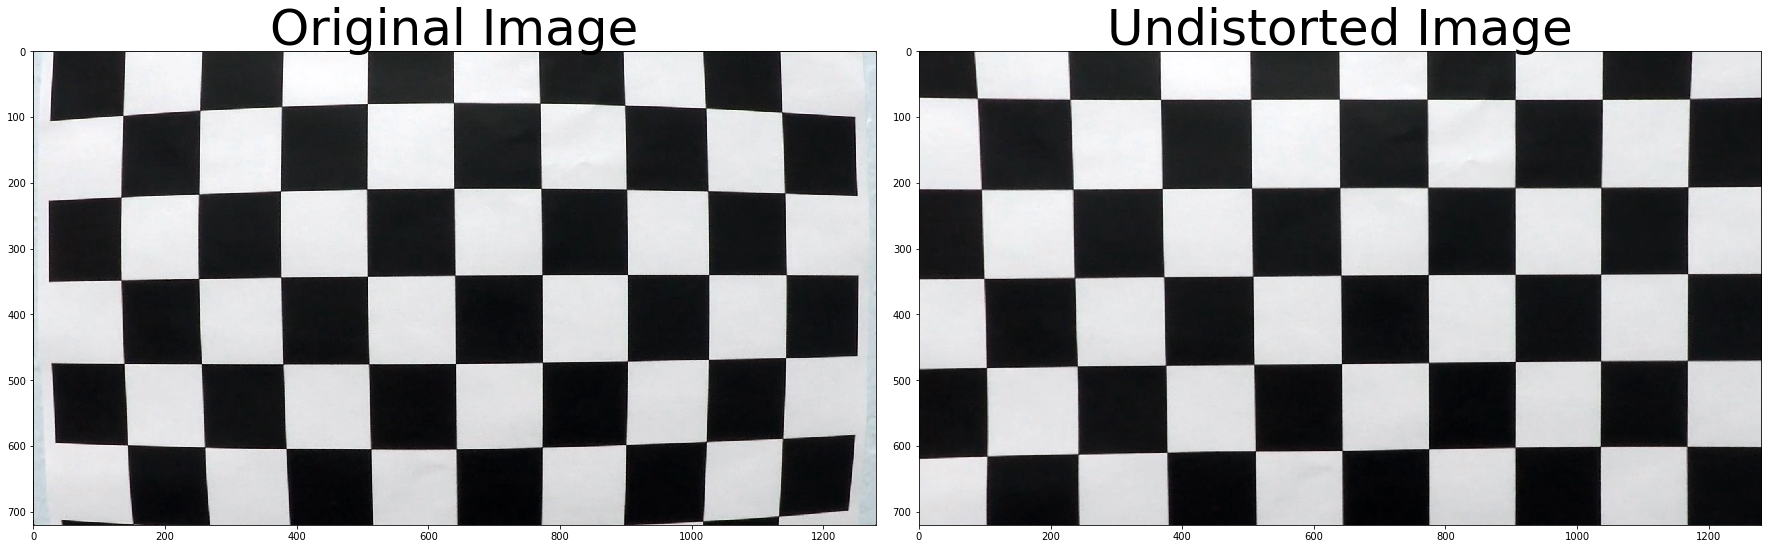

In [6]:
# Undistort a test image
img = cv2.imread('./camera_cal/calibration1.jpg')

undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)

def plotImageCompare(original, firstTitle, undistorted, secondTitle):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(original)
    ax1.set_title(firstTitle, fontsize=50)
    ax2.imshow(undistorted)
    ax2.set_title(secondTitle, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
plotImageCompare(img, "Original Image", undistorted_img, "Undistorted Image")

## Creating a binary image with clear lane lines

In [25]:
# Load a test image, convert to RGB and undistort it
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#Now that we have undistortion matrices, we just plug them in:
img = cv2.undistort(img, mtx, dist, None, mtx)

In the following process, we are combining two computer vision gradient and color isolation techniques. We ar first using the Sobel operator in the x direction which gives the gradient 

In [26]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    combined = np.zeros_like(s_channel)
    combined[((sxbinary == 1)) | ((s_binary == 1))] = 1

    

    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return combined

In [44]:
imgBinary = pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100))

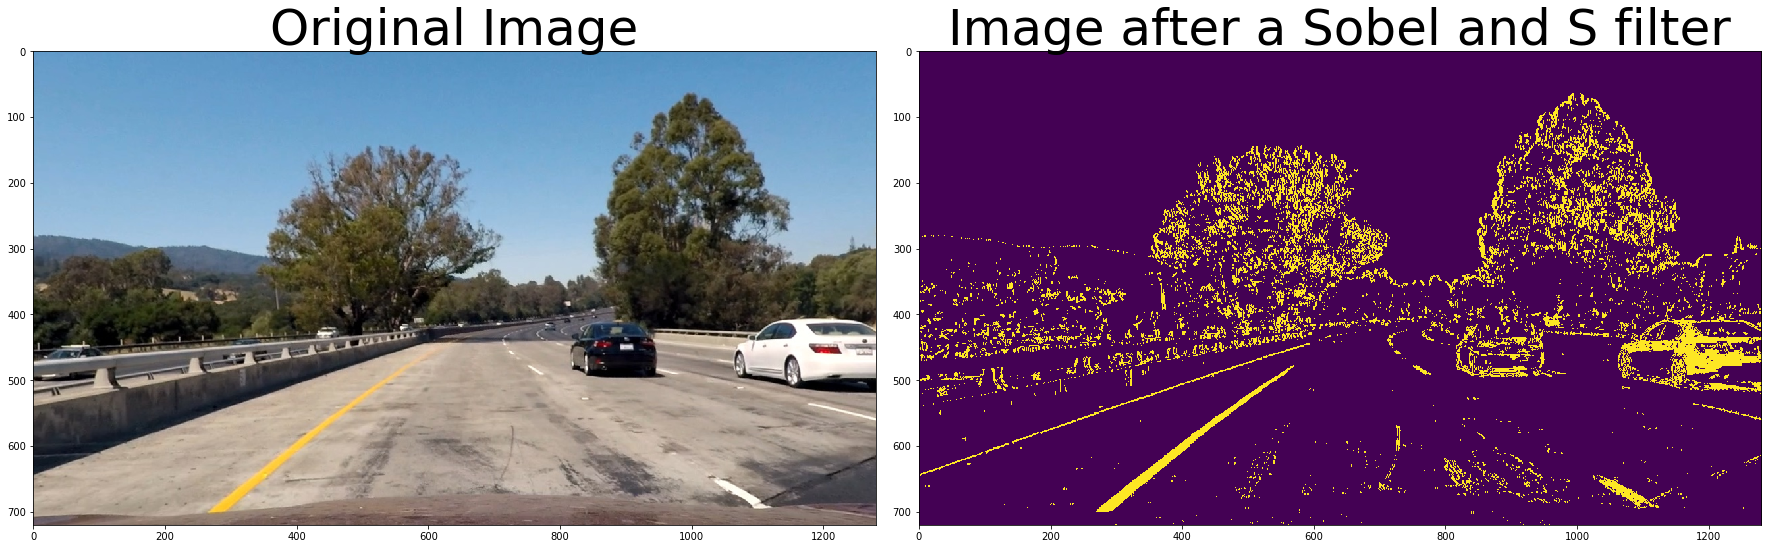

In [45]:
plotImageCompare(img,"Original Image", imgBinary, "Image after a Sobel and S filter")

## Changing the perspective:

In [46]:
def perspective_change(img, src=None, dst=None):
    # Define calibration box in source (original) and destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])
    
    #The src coordinates will be a trapezoid:
    if src is None:
        src = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right # Bottom right
    
    
    if dst is None:
        dst = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   

    # Compute the perspective transfor, M
    M = cv2.getPerspectiveTransform(src, dst)

    
    # Compute the inverse perspective transfor also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv

In [47]:
warped_img, _ , Minv  = perspective_change(img)


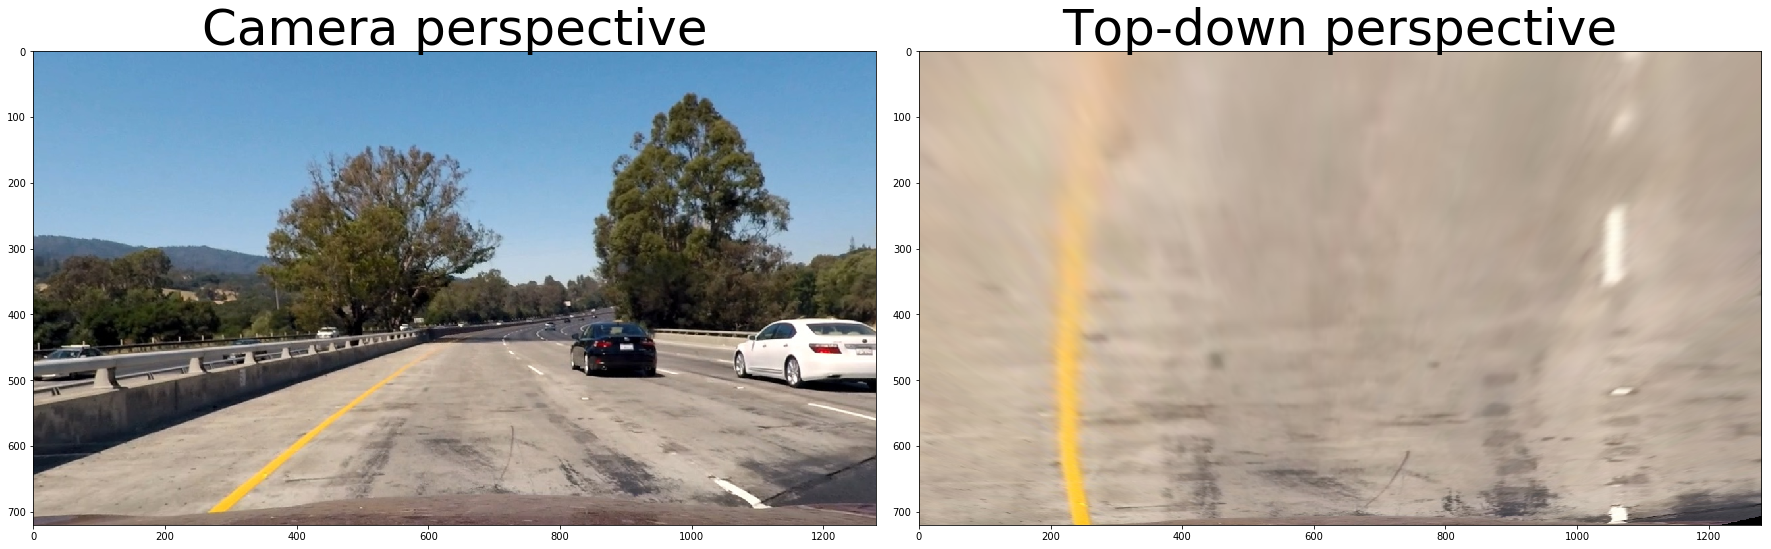

In [48]:
plotImageCompare(img,"Camera perspective", warped_img, "Top-down perspective")

In [49]:
def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram


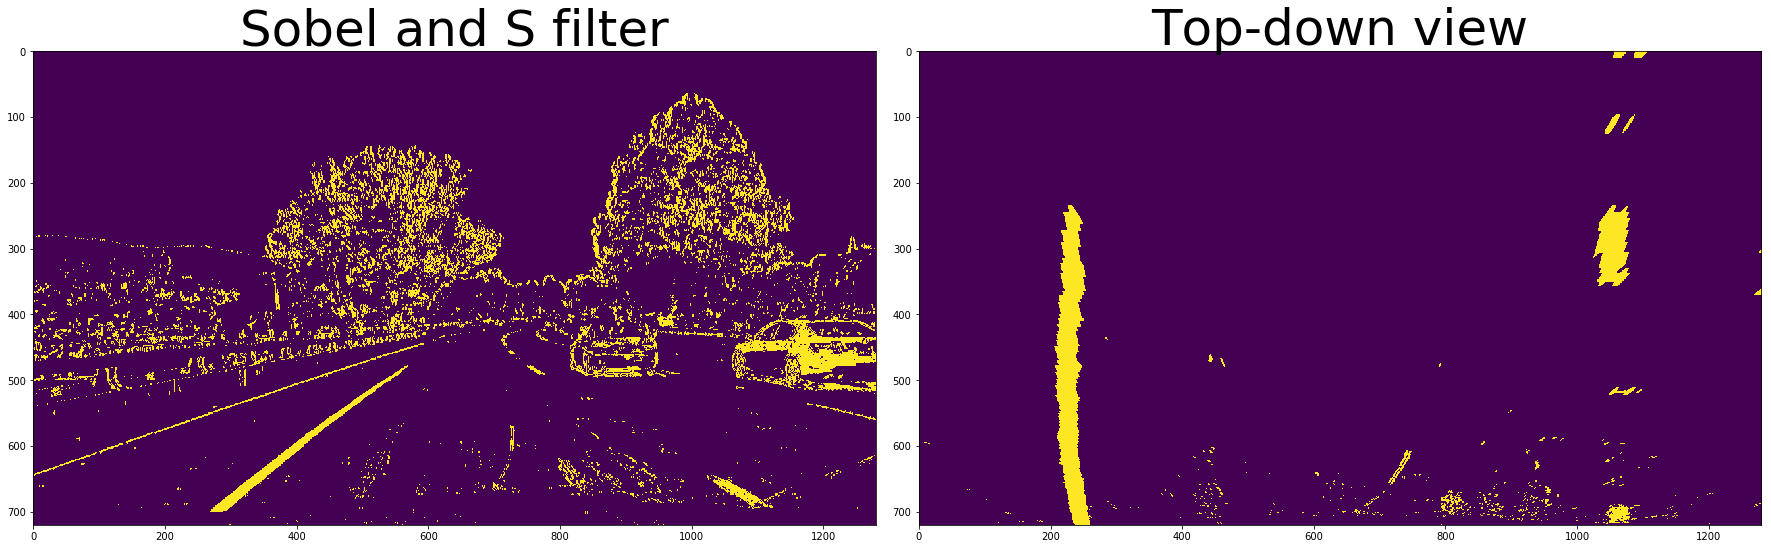

In [53]:
binary_warped, _ , Minv  = perspective_change(imgBinary)
plotImageCompare(imgBinary, "Sobel and S filter", binary_warped, "Top-down view")
histimg = hist(binary_warped)

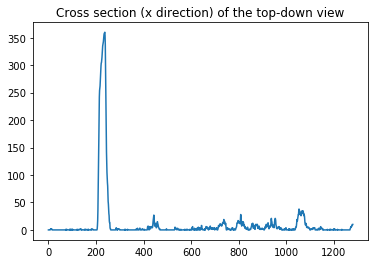

In [54]:
plt.title("Cross section (x direction) of the top-down view")
plt.plot(histimg)

In [55]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# Load our image

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    if (len(binary_warped.shape) == 2):
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    else:
        out_img= binary_warped
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        pass # Remove this when you add your function

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return out_img, ploty, left_fitx, right_fitx


out_img = fit_polynomial(binary_warped)[0]


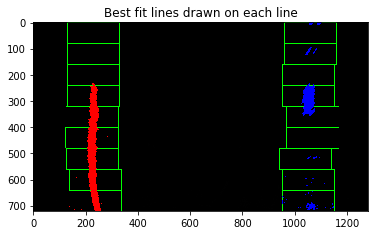

In [56]:
# Run the function
out_img, ploty, left_fitx, right_fitx = fit_polynomial(binary_warped)


# Plot the results
plt.title("Best fit lines drawn on each line")
plt.imshow(out_img)

## Measuring Curvature

In [58]:
def measure_curvature_real(img):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    leftx, lefty, rightx, righty, _ = find_lane_pixels(img)
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
        
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = np.power((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2),3/2)/np.absolute(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = np.power((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2),3/2)/np.absolute(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real(binary_warped)

print(left_curverad, 'm', right_curverad, 'm')

658.847259716 m 1448.60360174 m


In [66]:
def draw_region(img, warped_img, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    if (len(warp_zero.shape) == 2):
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    else:
        color_warp= warp_zero

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

In [60]:
print("right_fitx shape: "+ str(right_fitx.shape))
print("left_fitx shape: "+ str(left_fitx.shape))
print("ploty shape: "+ str(ploty.shape))

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)


right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


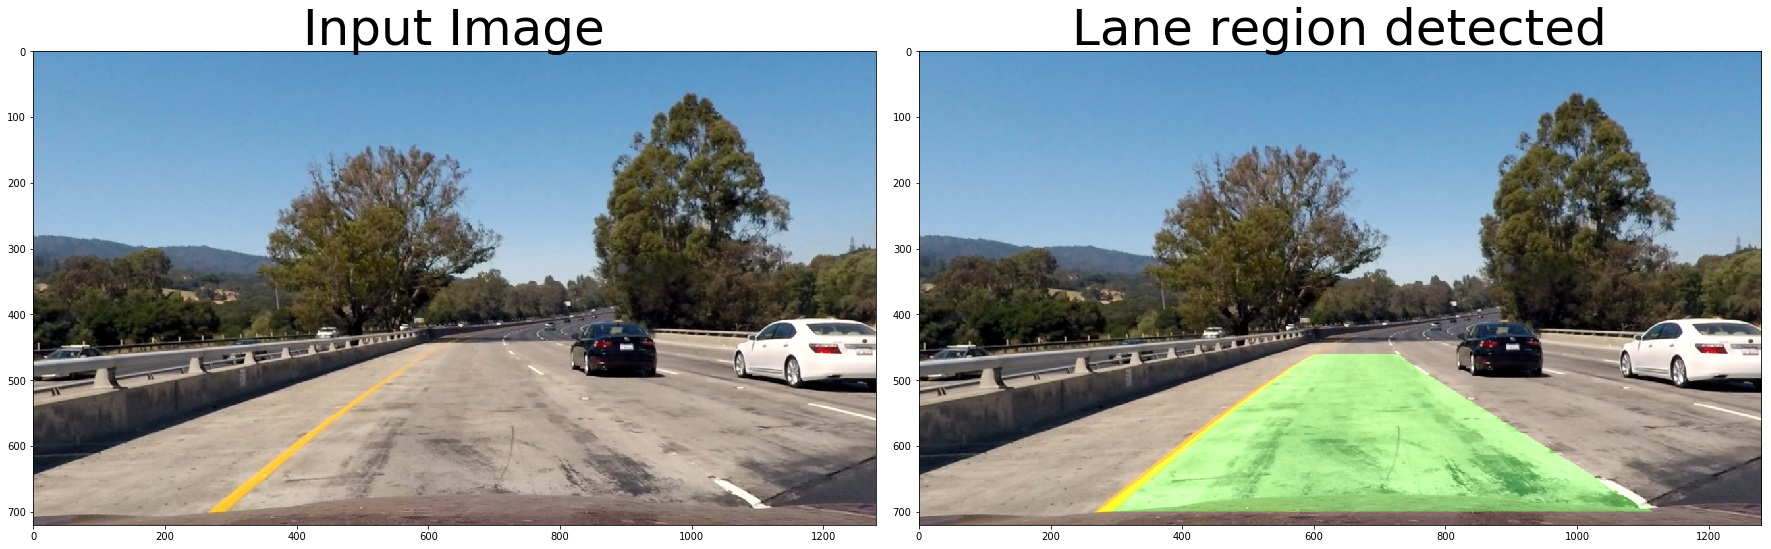

In [61]:
# Run the function
img_lane = draw_region(img, warped_img, left_fitx, right_fitx, ploty, Minv)

# Plot the results
plotImageCompare(img, 'Input Image', img_lane, 'Lane region detected')

In [62]:
def processImage(img):
        img = cv2.undistort(img, mtx, dist, None, mtx)

        # Finding the lane lines with Sobel filter and S filter
        combined = pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100))
        
        
#         src = np.float32(
#             [[280,  700],  # Bottom left
#              [595,  460],  # Top left
#              [725,  460],  # Top right
#              [1125, 700]]) # Bottom right

#         dst = np.float32(
#             [[250,  720],  # Bottom left
#              [250,    0],  # Top left
#              [1065,   0],  # Top right
#              [1065, 720]]) # Bottom right   

        # Now let us change the perspective. We will apply a transformation to our image to get a top-down view.
        src = None
        dst = None
        
        binary_warped, _, Minv = perspective_change(combined, src, dst)
        _, ploty, left_fitx, right_fitx = fit_polynomial(binary_warped)

        
        
        # Warp the detected lane boundaries back onto the original image.
        warped_img, _, Minv = perspective_change(img, src, dst)
        
        img_lane = draw_region(img, warped_img, left_fitx, right_fitx, ploty, Minv)
            
            
        return img_lane

In [63]:
class ImageProcessing:
    def __init__(self, images):
        # List out the images
        images = glob.glob(images)
        
        # Get camera calibration matrices
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = camera_calibration(images, 9, 6)
        #self.lines_fit_left = None
        #self.lines_fit_right = None

    def __call__(self, img):
        # Undistord the image
        img = glob.glob(img)
        img = cv2.undistort(img, mtx, dist, None, mtx)

        # Finding the lane lines with Sobel filter and S filter
        combined = pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100))
        
        
#         src = np.float32(
#             [[280,  700],  # Bottom left
#              [595,  460],  # Top left
#              [725,  460],  # Top right
#              [1125, 700]]) # Bottom right

#         dst = np.float32(
#             [[250,  720],  # Bottom left
#              [250,    0],  # Top left
#              [1065,   0],  # Top right
#              [1065, 720]]) # Bottom right   

        # Now let us change the perspective. We will apply a transformation to our image to get a top-down view.
        src = None
        dst = None
        
        binary_warped, _, Minv = perspective_change(combined, src, dst)
        _, ploty, left_fitx, right_fitx = fit_polynomial(binary_warped)

        
        
        # Warp the detected lane boundaries back onto the original image.
        warped_img, _, Minv = perspective_change(img, src, dst)
        
        img_lane = draw_region(img, warped_img, left_fitx, right_fitx, ploty, Minv)
            
            
        return img_lane

In [65]:
input_video = './project_video.mp4'
output_video = './project_video_solution.mp4'


clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
process_image = ImageProcessing('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(processImage)

%time white_clip.write_videofile(output_video, audio=False)

Successfully calibrated.
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
[MoviePy] >>>> Building video ./project_video_solution.mp4
[MoviePy] Writing video ./project_video_solution.mp4


  0%|          | 1/1261 [00:00<02:32,  8.27it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  0%|          | 3/1261 [00:00<03:49,  5.48it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  0%|          | 5/1261 [00:00<03:30,  5.97it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  1%|          | 7/1261 [00:01<03:00,  6.94it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  1%|          | 9/1261 [00:01<03:27,  6.02it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  1%|          | 11/1261 [00:01<03:16,  6.35it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  1%|          | 12/1261 [00:02<03:36,  5.78it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  1%|          | 14/1261 [00:02<03:22,  6.15it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  1%|▏         | 16/1261 [00:02<02:54,  7.15it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  1%|▏         | 18/1261 [00:02<02:58,  6.97it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  2%|▏         | 20/1261 [00:03<03:14,  6.39it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  2%|▏         | 21/1261 [00:03<03:25,  6.04it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  2%|▏         | 24/1261 [00:03<03:31,  5.85it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  2%|▏         | 26/1261 [00:04<03:08,  6.55it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  2%|▏         | 28/1261 [00:04<03:06,  6.60it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  2%|▏         | 30/1261 [00:04<03:10,  6.46it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  3%|▎         | 32/1261 [00:05<02:53,  7.07it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  3%|▎         | 33/1261 [00:05<02:55,  6.98it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  3%|▎         | 36/1261 [00:05<03:00,  6.79it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  3%|▎         | 38/1261 [00:06<02:53,  7.04it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  3%|▎         | 40/1261 [00:06<02:34,  7.90it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  3%|▎         | 42/1261 [00:06<02:32,  7.99it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  3%|▎         | 44/1261 [00:06<02:58,  6.84it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  4%|▎         | 46/1261 [00:07<02:45,  7.35it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  4%|▍         | 48/1261 [00:07<02:39,  7.61it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  4%|▍         | 50/1261 [00:07<02:29,  8.12it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  4%|▍         | 51/1261 [00:07<02:52,  7.00it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  4%|▍         | 53/1261 [00:08<03:23,  5.92it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  4%|▍         | 54/1261 [00:08<03:25,  5.87it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)

  4%|▍         | 56/1261 [00:08<03:40,  5.46it/s]


ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  5%|▍         | 58/1261 [00:09<03:25,  5.86it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  5%|▍         | 59/1261 [00:09<03:20,  5.99it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  5%|▍         | 62/1261 [00:09<03:07,  6.38it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  5%|▌         | 64/1261 [00:10<03:16,  6.10it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  5%|▌         | 65/1261 [00:10<03:41,  5.39it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  5%|▌         | 66/1261 [00:10<03:35,  5.56it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  5%|▌         | 67/1261 [00:10<03:50,  5.18it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  5%|▌         | 69/1261 [00:11<03:41,  5.38it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  6%|▌         | 72/1261 [00:11<03:43,  5.32it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  6%|▌         | 74/1261 [00:11<03:27,  5.71it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  6%|▌         | 75/1261 [00:12<03:46,  5.25it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  6%|▌         | 77/1261 [00:12<03:44,  5.28it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  6%|▋         | 79/1261 [00:12<03:42,  5.30it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  6%|▋         | 81/1261 [00:13<03:13,  6.09it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  7%|▋         | 83/1261 [00:13<03:14,  6.06it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  7%|▋         | 85/1261 [00:13<02:54,  6.72it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  7%|▋         | 87/1261 [00:14<02:45,  7.07it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  7%|▋         | 89/1261 [00:14<02:36,  7.49it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  7%|▋         | 91/1261 [00:14<02:43,  7.14it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  7%|▋         | 93/1261 [00:14<02:30,  7.74it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  7%|▋         | 94/1261 [00:14<02:27,  7.91it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  8%|▊         | 96/1261 [00:15<03:09,  6.13it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  8%|▊         | 99/1261 [00:15<03:23,  5.72it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  8%|▊         | 100/1261 [00:16<03:56,  4.90it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  8%|▊         | 101/1261 [00:16<03:54,  4.95it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  8%|▊         | 102/1261 [00:16<04:01,  4.79it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  8%|▊         | 103/1261 [00:16<04:02,  4.78it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  8%|▊         | 105/1261 [00:17<03:55,  4.91it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  8%|▊         | 106/1261 [00:17<04:34,  4.20it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  9%|▊         | 109/1261 [00:18<03:25,  5.60it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  9%|▊         | 110/1261 [00:18<03:14,  5.92it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  9%|▉         | 111/1261 [00:18<03:30,  5.46it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  9%|▉         | 113/1261 [00:18<03:37,  5.27it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  9%|▉         | 115/1261 [00:19<03:11,  6.00it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  9%|▉         | 116/1261 [00:19<03:01,  6.32it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


  9%|▉         | 119/1261 [00:19<03:20,  5.70it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 10%|▉         | 120/1261 [00:19<03:16,  5.79it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 10%|▉         | 122/1261 [00:20<03:43,  5.11it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 10%|▉         | 124/1261 [00:20<03:45,  5.05it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 10%|▉         | 126/1261 [00:21<03:17,  5.74it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 10%|█         | 127/1261 [00:21<03:27,  5.45it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 10%|█         | 129/1261 [00:21<03:22,  5.60it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 10%|█         | 131/1261 [00:21<02:49,  6.68it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 10%|█         | 132/1261 [00:22<02:54,  6.46it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 11%|█         | 135/1261 [00:22<03:12,  5.84it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 11%|█         | 137/1261 [00:22<02:45,  6.78it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 11%|█         | 139/1261 [00:23<03:03,  6.12it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 11%|█         | 141/1261 [00:23<03:00,  6.20it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 11%|█▏        | 142/1261 [00:23<03:01,  6.15it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 11%|█▏        | 144/1261 [00:24<03:34,  5.20it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 12%|█▏        | 146/1261 [00:24<03:34,  5.19it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)


 12%|█▏        | 147/1261 [00:24<03:59,  4.65it/s]

ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 12%|█▏        | 148/1261 [00:25<04:31,  4.10it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 12%|█▏        | 151/1261 [00:25<03:38,  5.07it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 12%|█▏        | 152/1261 [00:25<03:27,  5.34it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 12%|█▏        | 155/1261 [00:26<03:12,  5.76it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 12%|█▏        | 157/1261 [00:26<02:57,  6.21it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 13%|█▎        | 159/1261 [00:26<02:55,  6.27it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 13%|█▎        | 161/1261 [00:27<02:55,  6.26it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 13%|█▎        | 162/1261 [00:27<03:03,  5.98it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 13%|█▎        | 164/1261 [00:27<03:07,  5.84it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 13%|█▎        | 166/1261 [00:28<03:02,  5.99it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 13%|█▎        | 167/1261 [00:28<02:57,  6.17it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 13%|█▎        | 169/1261 [00:28<03:01,  6.03it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 14%|█▎        | 172/1261 [00:29<02:53,  6.28it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 14%|█▍        | 174/1261 [00:29<02:49,  6.39it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 14%|█▍        | 176/1261 [00:29<02:52,  6.28it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 14%|█▍        | 177/1261 [00:29<02:57,  6.11it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 14%|█▍        | 180/1261 [00:30<02:58,  6.05it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 14%|█▍        | 182/1261 [00:30<02:50,  6.31it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 15%|█▍        | 184/1261 [00:31<02:53,  6.20it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 15%|█▍        | 186/1261 [00:31<02:58,  6.02it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 15%|█▍        | 187/1261 [00:31<02:55,  6.12it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 15%|█▌        | 190/1261 [00:32<03:11,  5.59it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 15%|█▌        | 191/1261 [00:32<03:29,  5.10it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 15%|█▌        | 192/1261 [00:32<03:41,  4.82it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 15%|█▌        | 193/1261 [00:32<03:48,  4.67it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 16%|█▌        | 196/1261 [00:33<03:19,  5.33it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 16%|█▌        | 197/1261 [00:33<03:14,  5.47it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 16%|█▌        | 198/1261 [00:33<03:15,  5.45it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 16%|█▌        | 201/1261 [00:34<04:16,  4.14it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 16%|█▌        | 203/1261 [00:35<03:18,  5.33it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 16%|█▌        | 204/1261 [00:35<03:17,  5.36it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 16%|█▋        | 205/1261 [00:35<03:31,  4.99it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 16%|█▋        | 207/1261 [00:35<03:13,  5.46it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 17%|█▋        | 209/1261 [00:36<03:00,  5.82it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 17%|█▋        | 210/1261 [00:36<03:07,  5.60it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 17%|█▋        | 212/1261 [00:36<03:23,  5.15it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 17%|█▋        | 215/1261 [00:37<02:54,  6.01it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 17%|█▋        | 216/1261 [00:37<02:45,  6.32it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 17%|█▋        | 218/1261 [00:37<02:54,  5.97it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 17%|█▋        | 220/1261 [00:38<02:46,  6.25it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 18%|█▊        | 222/1261 [00:38<02:43,  6.36it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 18%|█▊        | 224/1261 [00:38<02:55,  5.91it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 18%|█▊        | 226/1261 [00:39<02:46,  6.23it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 18%|█▊        | 228/1261 [00:39<02:28,  6.97it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 18%|█▊        | 229/1261 [00:39<02:40,  6.43it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 18%|█▊        | 231/1261 [00:39<02:52,  5.97it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 18%|█▊        | 233/1261 [00:40<02:58,  5.76it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 19%|█▊        | 234/1261 [00:40<03:00,  5.69it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 19%|█▊        | 235/1261 [00:40<03:17,  5.20it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 19%|█▉        | 237/1261 [00:41<03:16,  5.22it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 19%|█▉        | 239/1261 [00:41<02:46,  6.13it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 19%|█▉        | 241/1261 [00:41<02:42,  6.29it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 19%|█▉        | 242/1261 [00:41<02:41,  6.32it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 19%|█▉        | 243/1261 [00:41<03:01,  5.62it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 19%|█▉        | 245/1261 [00:42<03:00,  5.63it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 20%|█▉        | 247/1261 [00:42<02:49,  6.00it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 20%|█▉        | 249/1261 [00:42<02:35,  6.52it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 20%|█▉        | 251/1261 [00:43<02:37,  6.42it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 20%|█▉        | 252/1261 [00:43<02:46,  6.06it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 20%|██        | 255/1261 [00:43<02:35,  6.46it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 20%|██        | 257/1261 [00:44<02:25,  6.92it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 20%|██        | 258/1261 [00:44<02:26,  6.86it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 21%|██        | 261/1261 [00:44<02:47,  5.98it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 21%|██        | 263/1261 [00:45<02:37,  6.33it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 21%|██        | 264/1261 [00:45<02:56,  5.64it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 21%|██        | 265/1261 [00:45<03:12,  5.16it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 21%|██        | 266/1261 [00:45<03:30,  4.72it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 21%|██▏       | 269/1261 [00:46<02:57,  5.59it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 21%|██▏       | 270/1261 [00:46<02:58,  5.55it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 21%|██▏       | 271/1261 [00:46<03:17,  5.02it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 22%|██▏       | 274/1261 [00:47<02:42,  6.09it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 22%|██▏       | 275/1261 [00:47<03:00,  5.47it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 22%|██▏       | 277/1261 [00:47<02:48,  5.85it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 22%|██▏       | 278/1261 [00:48<02:55,  5.60it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 22%|██▏       | 279/1261 [00:48<03:11,  5.13it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 22%|██▏       | 281/1261 [00:48<03:25,  4.78it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 22%|██▏       | 283/1261 [00:49<02:52,  5.67it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 23%|██▎       | 285/1261 [00:49<02:36,  6.25it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 23%|██▎       | 287/1261 [00:49<02:32,  6.38it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 23%|██▎       | 289/1261 [00:49<02:16,  7.12it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 23%|██▎       | 291/1261 [00:50<02:17,  7.07it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 23%|██▎       | 292/1261 [00:50<02:12,  7.30it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 23%|██▎       | 295/1261 [00:50<02:23,  6.75it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 24%|██▎       | 297/1261 [00:50<02:05,  7.66it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 24%|██▎       | 299/1261 [00:51<02:05,  7.69it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 24%|██▍       | 301/1261 [00:51<02:06,  7.57it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 24%|██▍       | 303/1261 [00:51<02:12,  7.23it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 24%|██▍       | 305/1261 [00:52<02:17,  6.98it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 24%|██▍       | 307/1261 [00:52<02:10,  7.31it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 25%|██▍       | 309/1261 [00:52<02:10,  7.31it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 25%|██▍       | 311/1261 [00:52<02:00,  7.88it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 25%|██▍       | 313/1261 [00:53<02:07,  7.46it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 25%|██▍       | 315/1261 [00:53<01:58,  8.00it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 25%|██▌       | 317/1261 [00:53<02:01,  7.74it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 25%|██▌       | 319/1261 [00:53<01:54,  8.21it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 25%|██▌       | 321/1261 [00:54<02:10,  7.20it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 26%|██▌       | 323/1261 [00:54<01:59,  7.83it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 26%|██▌       | 325/1261 [00:54<02:06,  7.42it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 26%|██▌       | 327/1261 [00:55<02:08,  7.25it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 26%|██▌       | 329/1261 [00:55<02:02,  7.63it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 26%|██▌       | 331/1261 [00:55<02:03,  7.54it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 26%|██▋       | 333/1261 [00:55<02:06,  7.33it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 27%|██▋       | 335/1261 [00:56<02:16,  6.80it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 27%|██▋       | 337/1261 [00:56<02:11,  7.04it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 27%|██▋       | 339/1261 [00:56<02:02,  7.54it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 27%|██▋       | 341/1261 [00:56<02:01,  7.57it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 27%|██▋       | 343/1261 [00:57<02:01,  7.56it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 27%|██▋       | 345/1261 [00:57<02:00,  7.63it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 28%|██▊       | 347/1261 [00:57<01:57,  7.80it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 28%|██▊       | 349/1261 [00:58<02:04,  7.30it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 28%|██▊       | 351/1261 [00:58<02:00,  7.57it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 28%|██▊       | 353/1261 [00:58<02:04,  7.28it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 28%|██▊       | 355/1261 [00:58<01:57,  7.70it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 28%|██▊       | 357/1261 [00:59<02:00,  7.52it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 28%|██▊       | 359/1261 [00:59<01:55,  7.84it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 29%|██▊       | 361/1261 [00:59<01:54,  7.88it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 29%|██▉       | 363/1261 [00:59<02:02,  7.32it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 29%|██▉       | 365/1261 [01:00<02:07,  7.04it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 29%|██▉       | 367/1261 [01:00<02:01,  7.38it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 29%|██▉       | 369/1261 [01:00<02:03,  7.23it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 29%|██▉       | 371/1261 [01:01<02:10,  6.84it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 30%|██▉       | 373/1261 [01:01<02:01,  7.33it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 30%|██▉       | 375/1261 [01:01<02:03,  7.17it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 30%|██▉       | 377/1261 [01:01<02:02,  7.22it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 30%|██▉       | 378/1261 [01:02<01:59,  7.37it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 30%|███       | 381/1261 [01:02<01:57,  7.47it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 30%|███       | 383/1261 [01:02<01:54,  7.64it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 31%|███       | 385/1261 [01:02<01:57,  7.48it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 31%|███       | 387/1261 [01:03<01:55,  7.54it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 31%|███       | 388/1261 [01:03<02:06,  6.92it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 31%|███       | 391/1261 [01:03<02:03,  7.05it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 31%|███       | 393/1261 [01:04<02:04,  6.95it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 31%|███▏      | 395/1261 [01:04<02:00,  7.21it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 31%|███▏      | 397/1261 [01:04<01:56,  7.44it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 32%|███▏      | 399/1261 [01:04<01:49,  7.85it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 32%|███▏      | 401/1261 [01:05<01:51,  7.74it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 32%|███▏      | 403/1261 [01:05<01:52,  7.66it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 32%|███▏      | 405/1261 [01:05<01:55,  7.39it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 32%|███▏      | 406/1261 [01:05<01:58,  7.24it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 32%|███▏      | 407/1261 [01:06<02:44,  5.20it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)


 32%|███▏      | 408/1261 [01:06<02:41,  5.29it/s]

_


 32%|███▏      | 409/1261 [01:06<03:10,  4.47it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 33%|███▎      | 410/1261 [01:06<03:24,  4.17it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 33%|███▎      | 411/1261 [01:07<03:45,  3.77it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 33%|███▎      | 412/1261 [01:07<03:49,  3.70it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 33%|███▎      | 413/1261 [01:07<03:37,  3.90it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 33%|███▎      | 415/1261 [01:08<02:55,  4.82it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 33%|███▎      | 417/1261 [01:08<02:23,  5.89it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 33%|███▎      | 418/1261 [01:08<02:38,  5.31it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 33%|███▎      | 420/1261 [01:09<02:43,  5.14it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 33%|███▎      | 422/1261 [01:09<02:32,  5.50it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 34%|███▎      | 424/1261 [01:09<02:21,  5.93it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 34%|███▎      | 425/1261 [01:09<02:37,  5.32it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 34%|███▍      | 427/1261 [01:10<02:39,  5.24it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 34%|███▍      | 429/1261 [01:10<02:32,  5.47it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 34%|███▍      | 431/1261 [01:10<02:12,  6.25it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 34%|███▍      | 432/1261 [01:11<02:29,  5.53it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 34%|███▍      | 435/1261 [01:11<01:59,  6.89it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 35%|███▍      | 436/1261 [01:11<02:24,  5.71it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 35%|███▍      | 437/1261 [01:12<03:06,  4.41it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 35%|███▍      | 439/1261 [01:12<02:46,  4.93it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 35%|███▌      | 442/1261 [01:13<02:31,  5.41it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 35%|███▌      | 444/1261 [01:13<02:18,  5.91it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 35%|███▌      | 446/1261 [01:13<02:09,  6.30it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 36%|███▌      | 448/1261 [01:14<02:07,  6.39it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 36%|███▌      | 450/1261 [01:14<02:03,  6.59it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 36%|███▌      | 452/1261 [01:14<01:58,  6.81it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 36%|███▌      | 454/1261 [01:14<01:52,  7.16it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 36%|███▌      | 456/1261 [01:15<01:57,  6.86it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 36%|███▋      | 458/1261 [01:15<02:02,  6.57it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 36%|███▋      | 459/1261 [01:15<02:12,  6.04it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 37%|███▋      | 462/1261 [01:16<02:02,  6.50it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 37%|███▋      | 463/1261 [01:16<02:06,  6.33it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 37%|███▋      | 465/1261 [01:16<02:28,  5.37it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 37%|███▋      | 468/1261 [01:17<02:13,  5.95it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 37%|███▋      | 470/1261 [01:17<02:07,  6.20it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 37%|███▋      | 472/1261 [01:17<01:49,  7.17it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 38%|███▊      | 474/1261 [01:18<01:54,  6.88it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 38%|███▊      | 476/1261 [01:18<01:50,  7.09it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 38%|███▊      | 478/1261 [01:18<01:49,  7.16it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 38%|███▊      | 480/1261 [01:18<01:57,  6.63it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 38%|███▊      | 481/1261 [01:19<02:01,  6.44it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 38%|███▊      | 484/1261 [01:19<02:00,  6.43it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 39%|███▊      | 486/1261 [01:19<01:59,  6.49it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 39%|███▊      | 488/1261 [01:20<02:00,  6.39it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 39%|███▉      | 489/1261 [01:20<02:03,  6.25it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 39%|███▉      | 492/1261 [01:20<02:13,  5.74it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 39%|███▉      | 494/1261 [01:21<01:58,  6.49it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 39%|███▉      | 496/1261 [01:21<02:01,  6.31it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 39%|███▉      | 498/1261 [01:21<01:45,  7.25it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 40%|███▉      | 500/1261 [01:22<01:46,  7.12it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 40%|███▉      | 501/1261 [01:22<01:56,  6.55it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 40%|███▉      | 504/1261 [01:22<02:00,  6.27it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 40%|████      | 506/1261 [01:23<02:04,  6.06it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 40%|████      | 508/1261 [01:23<02:06,  5.95it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 40%|████      | 510/1261 [01:23<02:09,  5.79it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 41%|████      | 512/1261 [01:24<02:09,  5.80it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 41%|████      | 513/1261 [01:24<02:18,  5.39it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 41%|████      | 516/1261 [01:24<01:57,  6.34it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 41%|████      | 518/1261 [01:25<01:55,  6.44it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 41%|████      | 520/1261 [01:25<01:46,  6.96it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 41%|████▏     | 521/1261 [01:25<01:56,  6.34it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 42%|████▏     | 524/1261 [01:26<01:50,  6.69it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 42%|████▏     | 526/1261 [01:26<01:54,  6.40it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 42%|████▏     | 528/1261 [01:26<01:43,  7.12it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 42%|████▏     | 530/1261 [01:26<01:43,  7.03it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 42%|████▏     | 532/1261 [01:27<01:40,  7.28it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 42%|████▏     | 533/1261 [01:27<01:37,  7.48it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 43%|████▎     | 536/1261 [01:27<01:53,  6.40it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 43%|████▎     | 538/1261 [01:28<01:50,  6.54it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 43%|████▎     | 540/1261 [01:28<01:49,  6.59it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 43%|████▎     | 541/1261 [01:28<01:46,  6.74it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 43%|████▎     | 542/1261 [01:28<02:04,  5.78it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 43%|████▎     | 543/1261 [01:29<02:23,  5.01it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 43%|████▎     | 545/1261 [01:29<02:11,  5.44it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 43%|████▎     | 548/1261 [01:29<02:02,  5.84it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 44%|████▎     | 550/1261 [01:30<01:58,  6.00it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 44%|████▎     | 551/1261 [01:30<02:10,  5.45it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 44%|████▍     | 552/1261 [01:30<02:26,  4.85it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 44%|████▍     | 554/1261 [01:31<02:47,  4.21it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 44%|████▍     | 555/1261 [01:31<02:58,  3.95it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 44%|████▍     | 556/1261 [01:32<04:02,  2.90it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 44%|████▍     | 557/1261 [01:32<04:37,  2.53it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 44%|████▍     | 559/1261 [01:33<05:04,  2.31it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 44%|████▍     | 560/1261 [01:33<04:38,  2.51it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 44%|████▍     | 561/1261 [01:34<04:11,  2.79it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 45%|████▍     | 563/1261 [01:34<04:21,  2.67it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 45%|████▍     | 564/1261 [01:35<03:58,  2.92it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_

 45%|████▍     | 565/1261 [01:35<03:34,  3.24it/s]

 45%|████▍     | 567/1261 [01:35<02:45,  4.18it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 45%|████▌     | 568/1261 [01:36<02:43,  4.24it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 45%|████▌     | 569/1261 [01:36<02:47,  4.13it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 45%|████▌     | 572/1261 [01:36<02:12,  5.19it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 45%|████▌     | 573/1261 [01:37<02:13,  5.14it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 46%|████▌     | 576/1261 [01:37<01:56,  5.90it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 46%|████▌     | 578/1261 [01:37<01:53,  6.02it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 46%|████▌     | 580/1261 [01:38<01:46,  6.41it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 46%|████▌     | 582/1261 [01:38<01:43,  6.57it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 46%|████▋     | 584/1261 [01:38<01:45,  6.43it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 46%|████▋     | 586/1261 [01:39<01:39,  6.79it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 47%|████▋     | 588/1261 [01:39<01:36,  6.95it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 47%|████▋     | 589/1261 [01:39<01:36,  6.98it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 47%|████▋     | 591/1261 [01:39<01:49,  6.14it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 47%|████▋     | 593/1261 [01:40<02:01,  5.51it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 47%|████▋     | 596/1261 [01:40<01:46,  6.26it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 47%|████▋     | 598/1261 [01:40<01:40,  6.58it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 48%|████▊     | 599/1261 [01:41<01:48,  6.09it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 48%|████▊     | 600/1261 [01:41<02:11,  5.01it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 48%|████▊     | 601/1261 [01:41<02:16,  4.85it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 48%|████▊     | 602/1261 [01:41<02:13,  4.93it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 48%|████▊     | 603/1261 [01:42<02:22,  4.62it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 48%|████▊     | 605/1261 [01:42<02:05,  5.22it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 48%|████▊     | 608/1261 [01:42<01:49,  5.94it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 48%|████▊     | 609/1261 [01:43<01:55,  5.64it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 48%|████▊     | 611/1261 [01:43<02:03,  5.25it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 49%|████▊     | 613/1261 [01:43<01:58,  5.45it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 49%|████▊     | 614/1261 [01:44<02:16,  4.73it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 49%|████▉     | 617/1261 [01:44<01:47,  6.01it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 49%|████▉     | 618/1261 [01:44<01:54,  5.60it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 49%|████▉     | 620/1261 [01:45<01:53,  5.62it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 49%|████▉     | 622/1261 [01:45<01:43,  6.19it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 49%|████▉     | 624/1261 [01:45<01:34,  6.72it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 50%|████▉     | 625/1261 [01:45<01:40,  6.32it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 50%|████▉     | 628/1261 [01:46<01:35,  6.64it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 50%|████▉     | 630/1261 [01:46<01:33,  6.72it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 50%|█████     | 631/1261 [01:46<01:38,  6.38it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 50%|█████     | 633/1261 [01:47<01:41,  6.19it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 50%|█████     | 635/1261 [01:47<01:36,  6.47it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 51%|█████     | 637/1261 [01:47<01:29,  6.99it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 51%|█████     | 639/1261 [01:48<01:30,  6.87it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 51%|█████     | 641/1261 [01:48<01:25,  7.27it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 51%|█████     | 642/1261 [01:48<01:37,  6.36it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 51%|█████     | 644/1261 [01:48<01:31,  6.74it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 51%|█████     | 646/1261 [01:49<01:33,  6.61it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 51%|█████▏    | 648/1261 [01:49<01:31,  6.71it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 52%|█████▏    | 650/1261 [01:49<01:30,  6.73it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 52%|█████▏    | 652/1261 [01:50<01:33,  6.49it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 52%|█████▏    | 654/1261 [01:50<01:25,  7.08it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 52%|█████▏    | 656/1261 [01:50<01:26,  7.00it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 52%|█████▏    | 657/1261 [01:50<01:29,  6.72it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 52%|█████▏    | 660/1261 [01:51<01:30,  6.65it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 52%|█████▏    | 662/1261 [01:51<01:27,  6.81it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 53%|█████▎    | 664/1261 [01:51<01:26,  6.86it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 53%|█████▎    | 666/1261 [01:52<01:30,  6.60it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 53%|█████▎    | 668/1261 [01:52<01:28,  6.73it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 53%|█████▎    | 670/1261 [01:52<01:27,  6.76it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 53%|█████▎    | 672/1261 [01:53<01:28,  6.65it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 53%|█████▎    | 673/1261 [01:53<01:31,  6.40it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 54%|█████▎    | 676/1261 [01:53<01:20,  7.30it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 54%|█████▎    | 677/1261 [01:53<01:27,  6.64it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 54%|█████▍    | 680/1261 [01:54<01:24,  6.86it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 54%|█████▍    | 682/1261 [01:54<01:24,  6.89it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 54%|█████▍    | 683/1261 [01:54<01:42,  5.62it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 54%|█████▍    | 684/1261 [01:55<01:53,  5.08it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 54%|█████▍    | 685/1261 [01:55<02:20,  4.11it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 54%|█████▍    | 686/1261 [01:55<02:26,  3.92it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 54%|█████▍    | 687/1261 [01:56<02:57,  3.24it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 55%|█████▍    | 688/1261 [01:56<02:55,  3.26it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 55%|█████▍    | 690/1261 [01:56<02:33,  3.71it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 55%|█████▍    | 691/1261 [01:57<02:21,  4.03it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 55%|█████▍    | 693/1261 [01:57<01:58,  4.78it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 55%|█████▌    | 695/1261 [01:57<01:49,  5.16it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 55%|█████▌    | 697/1261 [01:58<01:35,  5.89it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 55%|█████▌    | 699/1261 [01:58<01:31,  6.14it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 56%|█████▌    | 700/1261 [01:58<01:41,  5.53it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 56%|█████▌    | 702/1261 [01:58<01:40,  5.58it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 56%|█████▌    | 703/1261 [01:59<01:40,  5.55it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 56%|█████▌    | 706/1261 [01:59<01:41,  5.45it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 56%|█████▌    | 708/1261 [02:00<01:33,  5.91it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 56%|█████▋    | 710/1261 [02:00<01:26,  6.40it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 56%|█████▋    | 712/1261 [02:00<01:21,  6.71it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 57%|█████▋    | 714/1261 [02:00<01:22,  6.65it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 57%|█████▋    | 715/1261 [02:01<01:23,  6.54it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 57%|█████▋    | 718/1261 [02:01<01:20,  6.71it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 57%|█████▋    | 720/1261 [02:01<01:21,  6.65it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 57%|█████▋    | 722/1261 [02:02<01:18,  6.88it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 57%|█████▋    | 724/1261 [02:02<01:15,  7.10it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 58%|█████▊    | 726/1261 [02:02<01:12,  7.34it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 58%|█████▊    | 728/1261 [02:02<01:14,  7.14it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 58%|█████▊    | 730/1261 [02:03<01:12,  7.37it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 58%|█████▊    | 732/1261 [02:03<01:19,  6.63it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 58%|█████▊    | 734/1261 [02:03<01:21,  6.50it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 58%|█████▊    | 736/1261 [02:04<01:18,  6.71it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 59%|█████▊    | 738/1261 [02:04<01:29,  5.82it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 59%|█████▊    | 740/1261 [02:04<01:22,  6.30it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 59%|█████▉    | 742/1261 [02:05<01:17,  6.74it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 59%|█████▉    | 744/1261 [02:05<01:09,  7.43it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 59%|█████▉    | 746/1261 [02:05<01:09,  7.40it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 59%|█████▉    | 748/1261 [02:05<01:05,  7.83it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 59%|█████▉    | 750/1261 [02:06<01:07,  7.56it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 60%|█████▉    | 752/1261 [02:06<01:03,  8.04it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 60%|█████▉    | 754/1261 [02:06<01:08,  7.38it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 60%|█████▉    | 756/1261 [02:06<01:04,  7.84it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 60%|██████    | 758/1261 [02:07<01:11,  7.04it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 60%|██████    | 760/1261 [02:07<01:11,  6.99it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 60%|██████    | 762/1261 [02:07<01:10,  7.05it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 61%|██████    | 764/1261 [02:08<01:07,  7.32it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 61%|██████    | 766/1261 [02:08<01:09,  7.08it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 61%|██████    | 768/1261 [02:08<01:10,  6.99it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 61%|██████    | 770/1261 [02:08<01:06,  7.37it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 61%|██████    | 772/1261 [02:09<01:05,  7.41it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 61%|██████▏   | 774/1261 [02:09<01:00,  8.02it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 62%|██████▏   | 776/1261 [02:09<01:02,  7.71it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 62%|██████▏   | 778/1261 [02:09<01:05,  7.36it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 62%|██████▏   | 780/1261 [02:10<01:09,  6.90it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 62%|██████▏   | 782/1261 [02:10<01:05,  7.27it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 62%|██████▏   | 784/1261 [02:10<01:08,  6.98it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 62%|██████▏   | 786/1261 [02:11<01:08,  6.90it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 62%|██████▏   | 788/1261 [02:11<01:02,  7.52it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 63%|██████▎   | 789/1261 [02:11<01:18,  5.99it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 63%|██████▎   | 790/1261 [02:11<01:41,  4.65it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 63%|██████▎   | 791/1261 [02:12<01:42,  4.58it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 63%|██████▎   | 792/1261 [02:12<01:56,  4.04it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 63%|██████▎   | 793/1261 [02:12<02:01,  3.87it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 63%|██████▎   | 794/1261 [02:13<01:54,  4.08it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 63%|██████▎   | 796/1261 [02:13<01:46,  4.38it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 63%|██████▎   | 798/1261 [02:13<01:36,  4.80it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 63%|██████▎   | 800/1261 [02:14<01:18,  5.90it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 64%|██████▎   | 802/1261 [02:14<01:14,  6.18it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 64%|██████▎   | 803/1261 [02:14<01:12,  6.35it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 64%|██████▍   | 806/1261 [02:15<01:16,  5.97it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 64%|██████▍   | 807/1261 [02:15<01:25,  5.29it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 64%|██████▍   | 808/1261 [02:15<01:32,  4.88it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 64%|██████▍   | 811/1261 [02:16<01:25,  5.28it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 64%|██████▍   | 812/1261 [02:16<01:26,  5.21it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 65%|██████▍   | 815/1261 [02:16<01:09,  6.44it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 65%|██████▍   | 817/1261 [02:17<01:12,  6.16it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 65%|██████▍   | 818/1261 [02:17<01:13,  6.00it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 65%|██████▍   | 819/1261 [02:17<01:20,  5.51it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 65%|██████▌   | 822/1261 [02:18<01:14,  5.93it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 65%|██████▌   | 824/1261 [02:18<01:08,  6.42it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 66%|██████▌   | 826/1261 [02:18<01:01,  7.04it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 66%|██████▌   | 828/1261 [02:18<01:00,  7.17it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 66%|██████▌   | 830/1261 [02:19<00:56,  7.57it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 66%|██████▌   | 832/1261 [02:19<01:02,  6.85it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 66%|██████▌   | 834/1261 [02:19<00:59,  7.19it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 66%|██████▋   | 836/1261 [02:19<01:03,  6.74it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 66%|██████▋   | 837/1261 [02:20<01:05,  6.52it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 67%|██████▋   | 840/1261 [02:20<01:11,  5.90it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 67%|██████▋   | 842/1261 [02:21<01:07,  6.19it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 67%|██████▋   | 843/1261 [02:21<01:08,  6.08it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 67%|██████▋   | 846/1261 [02:21<01:12,  5.70it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 67%|██████▋   | 848/1261 [02:22<01:06,  6.25it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 67%|██████▋   | 849/1261 [02:22<01:02,  6.55it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 67%|██████▋   | 850/1261 [02:22<01:18,  5.25it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 68%|██████▊   | 852/1261 [02:22<01:13,  5.56it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 68%|██████▊   | 855/1261 [02:23<01:06,  6.09it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 68%|██████▊   | 856/1261 [02:23<01:11,  5.68it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 68%|██████▊   | 858/1261 [02:23<01:17,  5.19it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 68%|██████▊   | 860/1261 [02:24<01:11,  5.60it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 68%|██████▊   | 861/1261 [02:24<01:15,  5.27it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 69%|██████▊   | 864/1261 [02:24<01:07,  5.85it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 69%|██████▊   | 865/1261 [02:25<01:15,  5.25it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 69%|██████▉   | 867/1261 [02:25<01:14,  5.26it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 69%|██████▉   | 869/1261 [02:25<01:07,  5.84it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 69%|██████▉   | 870/1261 [02:26<01:10,  5.56it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 69%|██████▉   | 871/1261 [02:26<01:18,  4.94it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 69%|██████▉   | 874/1261 [02:26<01:07,  5.71it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 69%|██████▉   | 875/1261 [02:27<01:12,  5.35it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 69%|██████▉   | 876/1261 [02:27<01:20,  4.78it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 70%|██████▉   | 877/1261 [02:27<01:25,  4.49it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)


 70%|██████▉   | 878/1261 [02:27<01:25,  4.48it/s]

_


 70%|██████▉   | 879/1261 [02:28<01:28,  4.33it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 70%|██████▉   | 882/1261 [02:28<01:18,  4.82it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 70%|███████   | 884/1261 [02:28<01:06,  5.67it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 70%|███████   | 886/1261 [02:29<01:05,  5.73it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 70%|███████   | 888/1261 [02:29<00:57,  6.50it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 71%|███████   | 890/1261 [02:29<00:54,  6.76it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 71%|███████   | 892/1261 [02:30<00:49,  7.51it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 71%|███████   | 894/1261 [02:30<00:51,  7.18it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 71%|███████   | 895/1261 [02:30<00:49,  7.33it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 71%|███████   | 896/1261 [02:30<01:00,  6.08it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 71%|███████   | 897/1261 [02:30<01:05,  5.56it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 71%|███████   | 898/1261 [02:31<01:12,  4.99it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 71%|███████▏  | 899/1261 [02:31<01:20,  4.52it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 71%|███████▏  | 901/1261 [02:31<01:16,  4.69it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 72%|███████▏  | 903/1261 [02:32<01:01,  5.82it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 72%|███████▏  | 904/1261 [02:32<01:01,  5.82it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 72%|███████▏  | 905/1261 [02:32<01:07,  5.29it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 72%|███████▏  | 908/1261 [02:33<01:00,  5.86it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 72%|███████▏  | 910/1261 [02:33<00:57,  6.08it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 72%|███████▏  | 911/1261 [02:33<00:58,  5.96it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 72%|███████▏  | 913/1261 [02:33<01:05,  5.31it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 73%|███████▎  | 916/1261 [02:34<00:54,  6.31it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 73%|███████▎  | 918/1261 [02:34<00:48,  7.00it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 73%|███████▎  | 920/1261 [02:34<00:48,  7.05it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 73%|███████▎  | 922/1261 [02:35<00:49,  6.89it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 73%|███████▎  | 924/1261 [02:35<00:51,  6.58it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 73%|███████▎  | 926/1261 [02:35<00:48,  6.97it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 74%|███████▎  | 928/1261 [02:36<00:46,  7.22it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 74%|███████▍  | 930/1261 [02:36<00:45,  7.29it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 74%|███████▍  | 932/1261 [02:36<00:44,  7.44it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 74%|███████▍  | 934/1261 [02:36<00:44,  7.35it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 74%|███████▍  | 936/1261 [02:37<00:46,  7.00it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 74%|███████▍  | 938/1261 [02:37<00:44,  7.29it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 75%|███████▍  | 940/1261 [02:37<00:44,  7.25it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 75%|███████▍  | 941/1261 [02:37<00:48,  6.63it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 75%|███████▍  | 942/1261 [02:38<00:56,  5.67it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 75%|███████▍  | 943/1261 [02:38<00:59,  5.35it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 75%|███████▍  | 944/1261 [02:38<01:04,  4.94it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 75%|███████▍  | 945/1261 [02:38<01:04,  4.93it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 75%|███████▌  | 946/1261 [02:39<01:11,  4.42it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 75%|███████▌  | 949/1261 [02:39<00:53,  5.79it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 75%|███████▌  | 950/1261 [02:39<00:52,  5.93it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 76%|███████▌  | 953/1261 [02:40<00:47,  6.46it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 76%|███████▌  | 955/1261 [02:40<00:43,  7.07it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 76%|███████▌  | 957/1261 [02:40<00:43,  6.95it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 76%|███████▌  | 959/1261 [02:40<00:42,  7.11it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 76%|███████▌  | 961/1261 [02:41<00:40,  7.32it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 76%|███████▋  | 963/1261 [02:41<00:41,  7.25it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 77%|███████▋  | 965/1261 [02:41<00:39,  7.41it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 77%|███████▋  | 967/1261 [02:42<00:45,  6.45it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 77%|███████▋  | 968/1261 [02:42<00:53,  5.47it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 77%|███████▋  | 969/1261 [02:42<00:58,  4.99it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 77%|███████▋  | 971/1261 [02:43<00:59,  4.90it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 77%|███████▋  | 972/1261 [02:43<00:56,  5.10it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 77%|███████▋  | 975/1261 [02:43<00:50,  5.62it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 77%|███████▋  | 976/1261 [02:44<00:54,  5.24it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 78%|███████▊  | 978/1261 [02:44<00:54,  5.20it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 78%|███████▊  | 980/1261 [02:44<00:44,  6.34it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 78%|███████▊  | 981/1261 [02:44<00:43,  6.49it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 78%|███████▊  | 983/1261 [02:45<00:43,  6.46it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 78%|███████▊  | 984/1261 [02:45<00:43,  6.37it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 78%|███████▊  | 985/1261 [02:45<00:52,  5.25it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 78%|███████▊  | 986/1261 [02:45<00:58,  4.68it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 78%|███████▊  | 987/1261 [02:46<01:01,  4.49it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 78%|███████▊  | 989/1261 [02:46<00:54,  5.02it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 79%|███████▊  | 991/1261 [02:46<00:48,  5.61it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 79%|███████▊  | 992/1261 [02:46<00:47,  5.70it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 79%|███████▉  | 994/1261 [02:47<00:48,  5.52it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 79%|███████▉  | 995/1261 [02:47<00:45,  5.88it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 79%|███████▉  | 998/1261 [02:47<00:40,  6.55it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 79%|███████▉  | 1000/1261 [02:48<00:36,  7.06it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 79%|███████▉  | 1001/1261 [02:48<00:38,  6.80it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 80%|███████▉  | 1004/1261 [02:48<00:40,  6.33it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 80%|███████▉  | 1006/1261 [02:49<00:38,  6.66it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 80%|███████▉  | 1008/1261 [02:49<00:39,  6.40it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 80%|████████  | 1009/1261 [02:49<00:38,  6.46it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 80%|████████  | 1010/1261 [02:49<00:53,  4.72it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)

 80%|████████  | 1011/1261 [02:50<00:50,  4.91it/s]


Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 80%|████████  | 1014/1261 [02:50<00:48,  5.14it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 80%|████████  | 1015/1261 [02:50<00:49,  4.98it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 81%|████████  | 1016/1261 [02:51<00:54,  4.53it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 81%|████████  | 1017/1261 [02:51<00:48,  5.03it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)

 81%|████████  | 1018/1261 [02:51<00:51,  4.73it/s]


left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 81%|████████  | 1019/1261 [02:51<00:50,  4.84it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 81%|████████  | 1022/1261 [02:52<00:45,  5.28it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 81%|████████  | 1023/1261 [02:52<00:48,  4.94it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 81%|████████▏ | 1026/1261 [02:53<00:46,  5.10it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 81%|████████▏ | 1027/1261 [02:53<00:47,  4.97it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 82%|████████▏ | 1028/1261 [02:53<00:50,  4.59it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 82%|████████▏ | 1030/1261 [02:54<00:42,  5.42it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 82%|████████▏ | 1032/1261 [02:54<00:39,  5.77it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 82%|████████▏ | 1033/1261 [02:54<00:46,  4.92it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)


 82%|████████▏ | 1035/1261 [02:54<00:42,  5.33it/s]

_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 82%|████████▏ | 1037/1261 [02:55<00:42,  5.31it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 82%|████████▏ | 1038/1261 [02:55<00:42,  5.27it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 83%|████████▎ | 1041/1261 [02:56<00:42,  5.15it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 83%|████████▎ | 1043/1261 [02:56<00:38,  5.60it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 83%|████████▎ | 1044/1261 [02:56<00:48,  4.46it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 83%|████████▎ | 1045/1261 [02:56<00:46,  4.67it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 83%|████████▎ | 1047/1261 [02:57<00:46,  4.65it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 83%|████████▎ | 1048/1261 [02:57<00:50,  4.24it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 83%|████████▎ | 1051/1261 [02:58<00:39,  5.31it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 83%|████████▎ | 1052/1261 [02:58<00:43,  4.83it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 84%|████████▎ | 1053/1261 [02:58<00:48,  4.33it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 84%|████████▎ | 1055/1261 [02:59<00:47,  4.36it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 84%|████████▎ | 1056/1261 [02:59<00:43,  4.76it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 84%|████████▍ | 1058/1261 [02:59<00:47,  4.24it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 84%|████████▍ | 1059/1261 [03:00<00:50,  4.04it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 84%|████████▍ | 1061/1261 [03:00<00:42,  4.72it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 84%|████████▍ | 1063/1261 [03:00<00:37,  5.28it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 84%|████████▍ | 1065/1261 [03:01<00:40,  4.79it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 85%|████████▍ | 1068/1261 [03:01<00:35,  5.42it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 85%|████████▍ | 1069/1261 [03:02<00:44,  4.32it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 85%|████████▍ | 1070/1261 [03:02<00:41,  4.57it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 85%|████████▌ | 1072/1261 [03:02<00:34,  5.41it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 85%|████████▌ | 1074/1261 [03:03<00:36,  5.08it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 85%|████████▌ | 1077/1261 [03:03<00:31,  5.84it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 85%|████████▌ | 1078/1261 [03:03<00:34,  5.35it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 86%|████████▌ | 1080/1261 [03:04<00:30,  6.00it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 86%|████████▌ | 1081/1261 [03:04<00:32,  5.60it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 86%|████████▌ | 1082/1261 [03:04<00:31,  5.64it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 86%|████████▌ | 1084/1261 [03:04<00:27,  6.33it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 86%|████████▌ | 1087/1261 [03:05<00:28,  6.07it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 86%|████████▋ | 1089/1261 [03:05<00:25,  6.66it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 87%|████████▋ | 1091/1261 [03:05<00:25,  6.55it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 87%|████████▋ | 1092/1261 [03:05<00:25,  6.68it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 87%|████████▋ | 1095/1261 [03:06<00:24,  6.78it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 87%|████████▋ | 1097/1261 [03:06<00:24,  6.60it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 87%|████████▋ | 1099/1261 [03:07<00:26,  6.16it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 87%|████████▋ | 1100/1261 [03:07<00:26,  6.02it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 87%|████████▋ | 1102/1261 [03:07<00:39,  4.06it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 87%|████████▋ | 1103/1261 [03:08<00:43,  3.66it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 88%|████████▊ | 1104/1261 [03:08<00:45,  3.48it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 88%|████████▊ | 1105/1261 [03:08<00:43,  3.61it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 88%|████████▊ | 1106/1261 [03:09<00:40,  3.81it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)


 88%|████████▊ | 1108/1261 [03:09<00:33,  4.53it/s]

_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 88%|████████▊ | 1110/1261 [03:09<00:27,  5.42it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 88%|████████▊ | 1111/1261 [03:09<00:28,  5.19it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 88%|████████▊ | 1112/1261 [03:10<00:31,  4.66it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 88%|████████▊ | 1114/1261 [03:10<00:31,  4.66it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 89%|████████▊ | 1116/1261 [03:10<00:27,  5.28it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 89%|████████▊ | 1117/1261 [03:11<00:28,  5.13it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 89%|████████▉ | 1120/1261 [03:11<00:25,  5.58it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 89%|████████▉ | 1122/1261 [03:12<00:24,  5.67it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 89%|████████▉ | 1123/1261 [03:12<00:27,  5.04it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 89%|████████▉ | 1125/1261 [03:12<00:25,  5.35it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 89%|████████▉ | 1127/1261 [03:12<00:22,  6.00it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 89%|████████▉ | 1128/1261 [03:13<00:25,  5.28it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 90%|████████▉ | 1129/1261 [03:13<00:29,  4.44it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 90%|████████▉ | 1130/1261 [03:13<00:31,  4.16it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 90%|████████▉ | 1133/1261 [03:14<00:23,  5.40it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 90%|████████▉ | 1134/1261 [03:14<00:25,  5.04it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)


 90%|█████████ | 1135/1261 [03:14<00:25,  5.02it/s]

_


 90%|█████████ | 1137/1261 [03:15<00:23,  5.17it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 90%|█████████ | 1138/1261 [03:15<00:23,  5.28it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 90%|█████████ | 1141/1261 [03:15<00:23,  5.15it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 91%|█████████ | 1143/1261 [03:16<00:21,  5.49it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 91%|█████████ | 1145/1261 [03:16<00:19,  5.81it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 91%|█████████ | 1146/1261 [03:16<00:19,  5.84it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 91%|█████████ | 1148/1261 [03:17<00:22,  4.97it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 91%|█████████▏| 1151/1261 [03:17<00:19,  5.56it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 91%|█████████▏| 1152/1261 [03:17<00:19,  5.52it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 92%|█████████▏| 1155/1261 [03:18<00:16,  6.27it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 92%|█████████▏| 1157/1261 [03:18<00:16,  6.34it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 92%|█████████▏| 1159/1261 [03:18<00:15,  6.42it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 92%|█████████▏| 1161/1261 [03:19<00:15,  6.51it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 92%|█████████▏| 1163/1261 [03:19<00:15,  6.13it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 92%|█████████▏| 1165/1261 [03:19<00:14,  6.50it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 93%|█████████▎| 1167/1261 [03:20<00:12,  7.28it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 93%|█████████▎| 1169/1261 [03:20<00:12,  7.24it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 93%|█████████▎| 1171/1261 [03:20<00:12,  7.31it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 93%|█████████▎| 1173/1261 [03:20<00:11,  7.51it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 93%|█████████▎| 1175/1261 [03:21<00:11,  7.27it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 93%|█████████▎| 1177/1261 [03:21<00:12,  6.90it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 93%|█████████▎| 1178/1261 [03:21<00:13,  6.26it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 93%|█████████▎| 1179/1261 [03:22<00:15,  5.36it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 94%|█████████▎| 1180/1261 [03:22<00:17,  4.64it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 94%|█████████▎| 1181/1261 [03:22<00:18,  4.42it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 94%|█████████▎| 1182/1261 [03:22<00:19,  4.01it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 94%|█████████▍| 1183/1261 [03:23<00:19,  4.08it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 94%|█████████▍| 1185/1261 [03:23<00:17,  4.43it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 94%|█████████▍| 1187/1261 [03:23<00:14,  5.03it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 94%|█████████▍| 1188/1261 [03:24<00:14,  4.90it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 94%|█████████▍| 1190/1261 [03:24<00:16,  4.38it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 95%|█████████▍| 1193/1261 [03:25<00:11,  5.73it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 95%|█████████▍| 1195/1261 [03:25<00:10,  6.52it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 95%|█████████▍| 1197/1261 [03:25<00:10,  6.27it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 95%|█████████▌| 1199/1261 [03:25<00:08,  6.92it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 95%|█████████▌| 1201/1261 [03:26<00:08,  6.81it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 95%|█████████▌| 1203/1261 [03:26<00:08,  7.11it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 96%|█████████▌| 1205/1261 [03:26<00:07,  7.09it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 96%|█████████▌| 1207/1261 [03:27<00:07,  6.80it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 96%|█████████▌| 1208/1261 [03:27<00:08,  6.19it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 96%|█████████▌| 1211/1261 [03:27<00:07,  6.93it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 96%|█████████▌| 1213/1261 [03:27<00:06,  6.92it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 96%|█████████▋| 1214/1261 [03:28<00:06,  7.03it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 96%|█████████▋| 1216/1261 [03:28<00:08,  5.60it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 97%|█████████▋| 1217/1261 [03:28<00:09,  4.86it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 97%|█████████▋| 1218/1261 [03:29<00:08,  5.02it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 97%|█████████▋| 1219/1261 [03:29<00:08,  4.81it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 97%|█████████▋| 1222/1261 [03:29<00:06,  5.95it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 97%|█████████▋| 1223/1261 [03:29<00:06,  5.88it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)

 97%|█████████▋| 1224/1261 [03:30<00:07,  4.84it/s]


pts shape: (1, 1440, 2)
_


 97%|█████████▋| 1225/1261 [03:30<00:07,  4.92it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)


 97%|█████████▋| 1227/1261 [03:30<00:06,  5.09it/s]

_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 97%|█████████▋| 1228/1261 [03:30<00:06,  5.21it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 98%|█████████▊| 1230/1261 [03:31<00:06,  4.88it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 98%|█████████▊| 1231/1261 [03:31<00:06,  4.68it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 98%|█████████▊| 1232/1261 [03:32<00:10,  2.81it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 98%|█████████▊| 1233/1261 [03:32<00:10,  2.68it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 98%|█████████▊| 1235/1261 [03:33<00:07,  3.68it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 98%|█████████▊| 1237/1261 [03:33<00:06,  3.47it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 98%|█████████▊| 1238/1261 [03:33<00:06,  3.59it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 98%|█████████▊| 1239/1261 [03:34<00:06,  3.28it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 98%|█████████▊| 1241/1261 [03:35<00:09,  2.19it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 98%|█████████▊| 1242/1261 [03:35<00:07,  2.63it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 99%|█████████▊| 1243/1261 [03:36<00:06,  2.96it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 99%|█████████▊| 1245/1261 [03:36<00:03,  4.12it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 99%|█████████▉| 1248/1261 [03:36<00:02,  5.62it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 99%|█████████▉| 1250/1261 [03:37<00:01,  5.99it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 99%|█████████▉| 1252/1261 [03:37<00:01,  6.47it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


 99%|█████████▉| 1254/1261 [03:37<00:00,  7.11it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


100%|█████████▉| 1256/1261 [03:37<00:00,  7.54it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


100%|█████████▉| 1258/1261 [03:38<00:00,  7.34it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


100%|█████████▉| 1260/1261 [03:38<00:00,  7.77it/s]

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_solution.mp4 

CPU times: user 3min 20s, sys: 7.66 s, total: 3min 28s
Wall time: 3min 41s


In [67]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))